## Loading libraries

In [152]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import pickle
import numpy as np
from scipy.misc import imread, imsave
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from src.enhancer import ImageComparator
from src.enhancer.enhancers import ENHANCERS

from skimage.filters import gaussian

## Setting up paths

In [154]:
base_path = Path('test-3')
originals_path = base_path / 'original'
masks_path = base_path / 'mask'
weight_maps_path = base_path / 'weight-map'

## Loading z-values and image/segmentation

In [155]:
from matplotlib.ticker import NullLocator

def save_image(path, title, image):
    plt.gca().set_axis_off()
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    
    plt.imshow(image)
#     plt.title(title[:-5].replace("_"," "), y=-0.2, fontsize=32)
    plt.savefig(str(path), transparent = True, bbox_inches='tight', pad_inches=0)

In [156]:
from src.descriptors.descriptors import DESCRIPTORS

def enhance(keyword, zfile, zfile_l):
    zcollection = pickle.load(open(zfile, 'rb'))
    zcollection_l = pickle.load(open(zfile_l, 'rb'))

    image = imread(originals_path / ('%s.jpg' % keyword))
    mask_path = masks_path / ('%s-mask.png' % keyword)
    if mask_path.exists():
        seg_b = imread(mask_path).astype(np.bool)
    else:
        seg_b = imread(masks_path / ('%s-mask.jpg' % keyword)).astype(np.bool)
    
    
    image_comparator = ImageComparator()
    top_n = 3

    im_path = base_path / keyword
    im_path.mkdir(exist_ok=True, parents=True)

    # Global z, Global descriptor
    cis = image_comparator.compare(image, zcollection)[:top_n]
    for idx, ci in enumerate(cis):
        key = ci.key
        delta = ci.delta
        z_delta = zcollection.descriptors[key].descriptor * delta
        # Global enhancement
        result_g_g_g = ENHANCERS[key].enhance(image, z_delta, 1)
        save_image(im_path / ('ggg-%s.jpg' % (idx + 1)), key, result_g_g_g)
        # Local enhancement
        result_g_g_l = ENHANCERS[key].enhance(image, z_delta, 1, mask=seg_b)
        save_image(im_path / ('ggl-%s.jpg' % (idx + 1)), key, result_g_g_l)



    # Global z, Local descriptor
    cis = image_comparator.compare(image, zcollection, mask=seg_b)[:top_n]
    for idx, ci in enumerate(cis):
        key = ci.key
        delta = ci.delta
        z_delta = zcollection.descriptors[key].descriptor * delta
        # Global enhancement
        result_g_l_g = ENHANCERS[key].enhance(image, z_delta, 1)
        save_image(im_path / ('glg-%s.jpg' % (idx + 1)), key, result_g_l_g)
        # Local enhancement
        result_g_l_l = ENHANCERS[key].enhance(image, z_delta, 1, mask=seg_b)
        save_image(im_path / ('gll-%s.jpg' % (idx + 1)), key, result_g_l_l)



    # Local z, Global descriptor
    cis = image_comparator.compare(image, zcollection_l)[:top_n]
    for idx, ci in enumerate(cis):
        key = ci.key
        delta = ci.delta
        z_delta = zcollection.descriptors[key].descriptor * delta
        # Global enhancement
        result_l_g_g = ENHANCERS[key].enhance(image, z_delta, 1)
        save_image(im_path / ('lgg-%s.jpg' % (idx + 1)), key, result_l_g_g)
        # Local enhancement
        result_l_g_l = ENHANCERS[key].enhance(image, z_delta, 1, mask=seg_b)
        save_image(im_path / ('lgl-%s.jpg' % (idx + 1)), key, result_l_g_l)



    # Local z, Local descriptor
    cis = image_comparator.compare(image, zcollection_l, mask=seg_b)[:top_n]
    for idx, ci in enumerate(cis):
        key = ci.key
        delta = ci.delta
        z_delta = zcollection.descriptors[key].descriptor * delta
        # Global enhancement
        result_l_l_g = ENHANCERS[key].enhance(image, z_delta, 1)
        save_image(im_path / ('llg-%s.jpg' % (idx + 1)), key, result_l_l_g)
        # Local enhancement
        result_l_l_l = ENHANCERS[key].enhance(image, z_delta, 1, mask=seg_b)
        save_image(im_path / ('lll-%s.jpg' % (idx + 1)), key, result_l_l_l)

strawberry-2


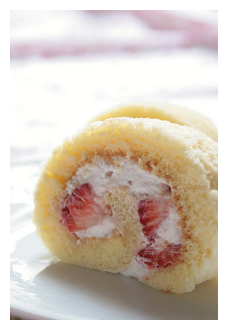

In [9]:
tuples = [
            ('strawberry-1', 'z-values/strawberry.pkl', 'z-values/strawberry-local.pkl'),
            ('strawberry-2', 'z-values/strawberry.pkl', 'z-values/strawberry-local.pkl'),
            ('strawberry-2-auto', 'z-values/strawberry.pkl', 'z-values/strawberry-local.pkl'),
            ('strawberry-3', 'z-values/strawberry.pkl', 'z-values/strawberry-local.pkl'),
            ('flickr-sunflower', 'z-values/sunflower.pkl', 'z-values/sunflower-local.pkl'),
            ('flickr-sunflower-2', 'z-values/sunflower.pkl', 'z-values/sunflower-local.pkl'),
            ('flickr-tulip', 'z-values/tulip.pkl', 'z-values/tulip-local.pkl'),
            ('flickr-cheese', 'z-values/cheese.pkl', 'z-values/cheese-local.pkl'),
            ('flickr-lily', 'z-values/lily.pkl', 'z-values/lily-local.pkl'),
            ('flickr-orchid', 'z-values/orchid.pkl', 'z-values/orchid-local.pkl'),
            ('banana-1', 'z-values/banana.pkl', 'z-values/banana-local.pkl'),
            ('cheese-1', 'z-values/cheese.pkl', 'z-values/cheese-local.pkl'),
            ('cheese-2', 'z-values/cheese.pkl', 'z-values/cheese-local.pkl'),
            ('dessert-1', 'z-values/dessert.pkl', 'z-values/dessert-local.pkl'),
         ]

for keyword, zfile, zfile_l in tuples[1:2]:
    print(keyword)
    enhance(keyword, zfile, zfile_l)

# First survey generation

In [6]:
from ipywidgets import widgets
from IPython.display import display

def enhance(image_path, mask_path, zfile, zfile_l, key, s, savename):
    chars = ['gray_hist', 'chroma_hist', 'hue_angle_hist', 'rgb_hist', 'lab_hist', 'lch_hist']
    buttons = {}
    for key in chars:
        button = widgets.Button(description=key)
        display(button)        
        buttons[key] = button
    
    image = imread(image_path)

    # GLOBAL
    zcollection = pickle.load(open(zfile, 'rb'))
    # LOCAL
    zcollection_l = pickle.load(open(zfile_l, 'rb'))
    mask = imread(mask_path)
    bmask = mask.astype(np.bool)
    h, w = mask.shape
    sigma = 0.05 * np.sqrt(h*h + w*w);
    g_mask = gaussian(mask, sigma)
    g_mask = np.dstack(3 * (g_mask,))
    
    plt.rcParams['figure.figsize'] = 10, 10
    rows = 1 + len(chars)

    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(g_mask, cmap='gray')
    plt.axis('off')
    plt.show()
    
    ge = {}
    le = {}
    
    for idx, key in enumerate(chars):
        # GLOBAL
        zv = zcollection.descriptors[key].descriptor
        image_comparator = ImageComparator()
        cis = image_comparator.compare_single(image, zcollection, key)
        genh = ENHANCERS[key].enhance(image, cis.delta * zv, s)

        # LOCAL
        zv = zcollection_l.descriptors[key].descriptor
        image_comparator = ImageComparator()
        cis = image_comparator.compare_single(image, zcollection_l, key, mask=bmask)
        enh = ENHANCERS[key].enhance(image, cis.delta * zv, s)
        result = (enh * g_mask + (1 - g_mask) * image).astype(np.uint8)

        plt.subplot(121)
        plt.imshow(genh)
        plt.axis('off')
        plt.title(key)
        plt.subplot(122)
        plt.imshow(result)
        plt.axis('off')
        plt.show()
        
        ge[key] = genh
        le[key] = result
    
        
    def save(img, k, g_img, l_img):
        original_path = 'DEMO/images_original/%s-%s' % (k, savename)
        global_path = 'DEMO/images_global/%s-%s' % (k, savename)
        local_path = 'DEMO/images_local/%s-%s' % (k, savename)

        imsave(original_path, img)
        imsave(global_path, g_img)
        imsave(local_path, l_img)
        
    for k, button in buttons.items():
        button.on_click(lambda b: save(image, b.description, ge[b.description], le[b.description]))

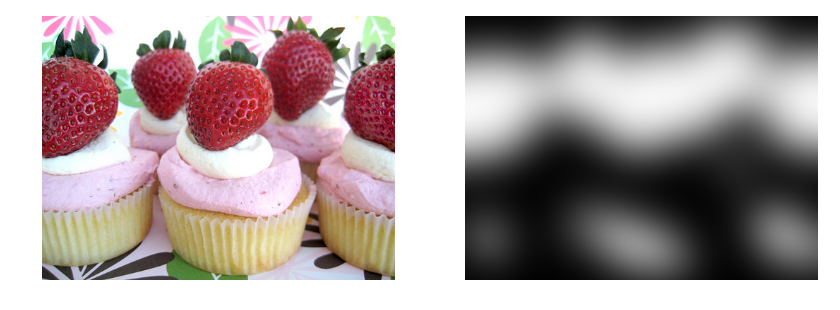

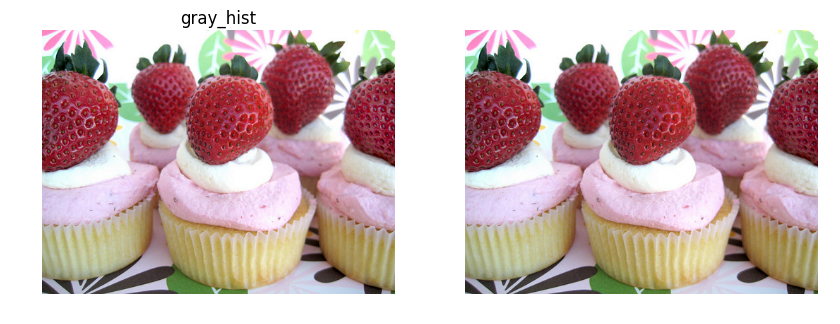

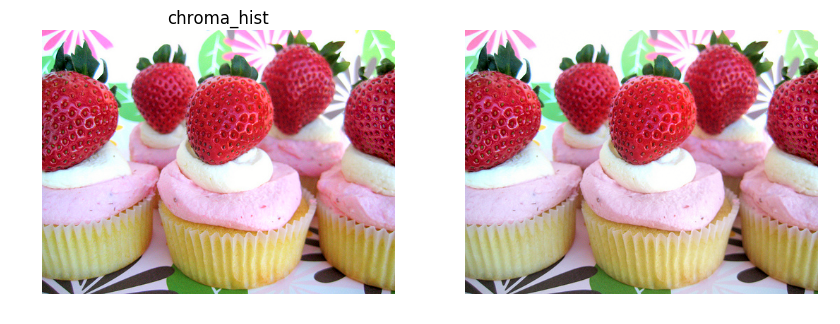

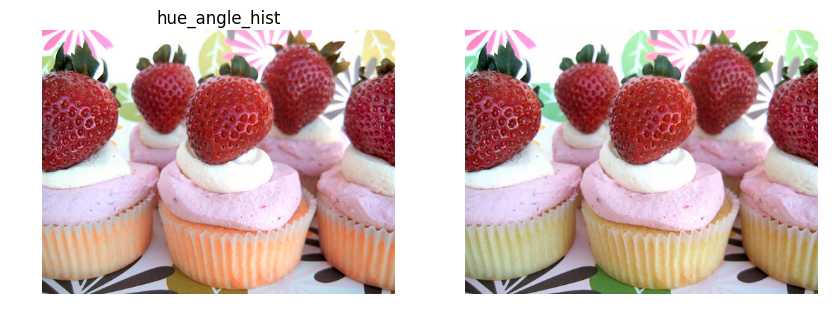

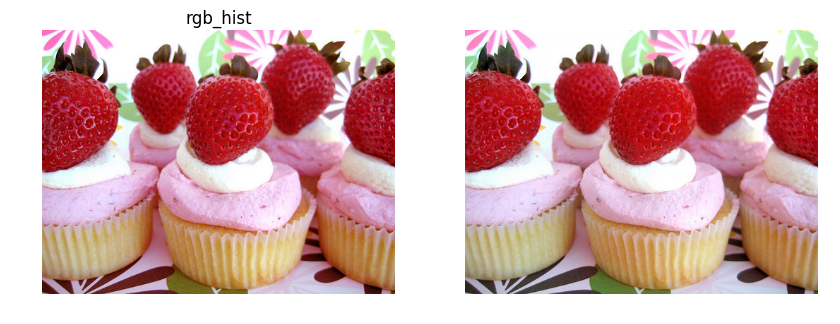

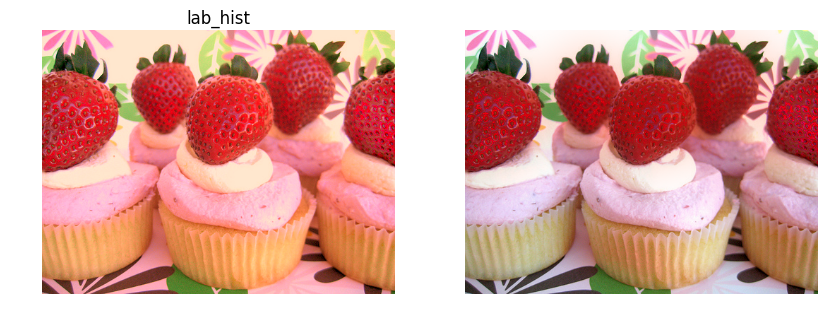

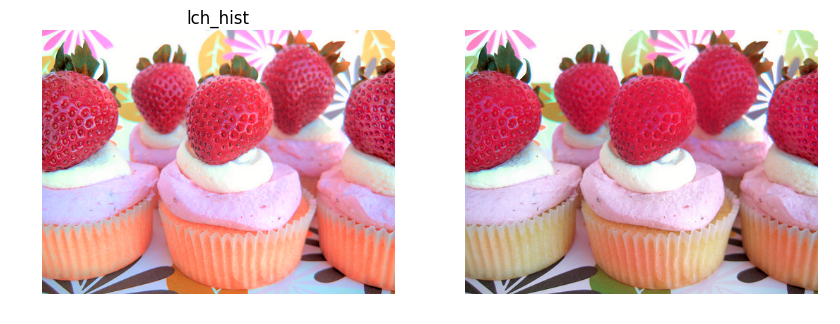

In [15]:
keyword = 'strawberry'
name = '2405.jpg'
image_path = 'images/%s/%s' % (keyword, name)
mask_path = 'masks/%s/%s' % (keyword, name)
s = 2

enhance(image_path, mask_path, 'z-values/%s.pkl' % keyword, 'z-values/%s-local.pkl' % keyword, 'gray_hist', s, name)

# Second survey generation

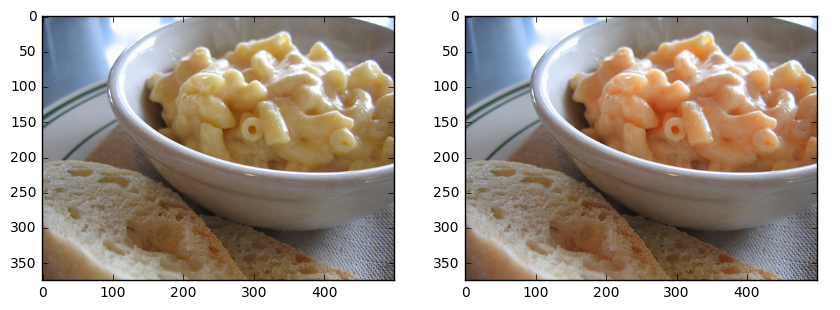

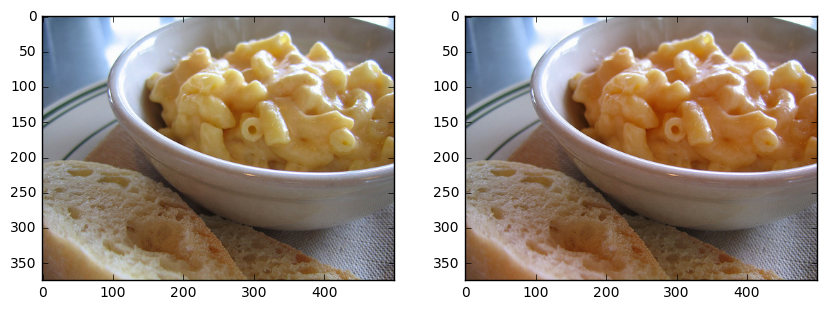

In [75]:
def enhance(image_path, mask_path, zfile_l, s, savename):
    image = imread(image_path)
    zcollection_l = pickle.load(open(zfile_l, 'rb'))

    mask = imread(mask_path)
    bmask = mask.astype(np.bool)
    h, w = mask.shape
    sigma = 0.05 * np.sqrt(h*h + w*w);
    g_mask = gaussian(mask, sigma)
    g_mask = np.dstack(3 * (g_mask,))

    image_comparator = ImageComparator()
    cis = image_comparator.compare(image, zcollection_l, mask=bmask)[:3]
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    enhs = []
    for idx, c in enumerate(cis):
        enh = ENHANCERS[c.key].enhance(image, c.delta_z, s)
        enh = (enh * g_mask + (1 - g_mask) * image).astype(np.uint8)
        enhs.append(enh)
        plt.subplot(1, 2, 1 + (1 + idx) % 2)
        plt.imshow(enh)
        if idx % 2 == 0:    
            plt.show()
            
    button = widgets.Button(description='save')
    display(button)
    
    def save(img, enhancements):
        original_path = 'Survey/images_original/%s' % savename
        rank1_path = 'Survey/images_rank1/%s' % savename
        rank2_path = 'Survey/images_rank2/%s' % savename
        rank3_path = 'Survey/images_rank3/%s' % savename

        imsave(original_path, img)
        imsave(rank1_path, enhancements[0])
        imsave(rank2_path, enhancements[1])
        imsave(rank3_path, enhancements[2])
    
    button.on_click(lambda b: save(image, enhs))
   
        

keyword = 'cheese'
name = '393859.jpg'
image_path = 'images/%s/%s' % (keyword, name)
mask_path = 'masks/%s/%s' % (keyword, name)
s = 1


enhance(image_path, mask_path, 'z-values/%s.pkl' % keyword, s, name)

In [47]:
def remove(savename):
    import os
    
    original_path = 'Survey/images_original/%s' % savename
    rank1_path = 'Survey/images_rank1/%s' % savename
    rank2_path = 'Survey/images_rank2/%s' % savename
    rank3_path = 'Survey/images_rank3/%s' % savename
    
    os.remove(original_path)
    os.remove(rank1_path)
    os.remove(rank2_path)
    os.remove(rank3_path)
    
remove('125405.jpg')

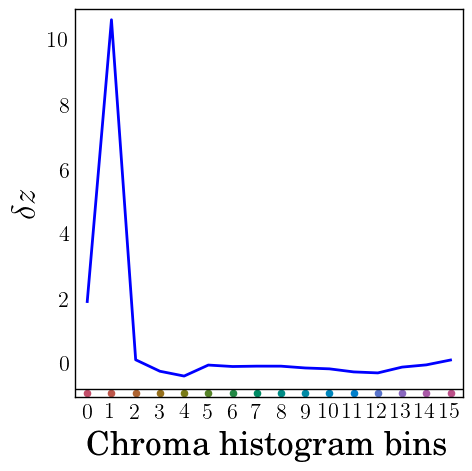

In [149]:
from scipy.interpolate import interp1d
from src.shared import rgb_chroma, rgb_hue

keyword = 'dessert'
name = '202576.jpg'
image_path = 'images/%s/%s' % (keyword, name)
mask_path = 'masks/%s/%s' % (keyword, name)

zfile_l = 'z-values/%s-local.pkl' % keyword

image = imread(image_path)

# LOCAL
zcollection_l = pickle.load(open(zfile_l, 'rb'))
mask = imread(mask_path)
bmask = mask.astype(np.bool)
h, w = mask.shape
sigma = 0.05 * np.sqrt(h*h + w*w);
g_mask = gaussian(mask, sigma)
g_mask = np.dstack(3 * (g_mask,))

plt.rcParams['figure.figsize'] = 5, 5

# LOCAL
key = 'hue_angle_hist'
zv = zcollection_l.descriptors[key].descriptor
image_comparator = ImageComparator()
cis = image_comparator.compare_single(image, zcollection_l, key, mask=bmask)

# DELTA Z
plt.rc('text', usetex=True)
plt.rcParams['font.family'] = 'Helvetica'


maxy = 11
axy = -0.75
dots = -0.87
miny = -1

plt.plot(cis.delta * zv, linewidth=2)
plt.xlabel('Chroma histogram bins', fontsize=24)
plt.ylabel(r'$\delta z$', fontsize=24)
plt.axhline(axy, color='black')
plt.xlim([-0.5, 15.5])
plt.ylim([miny, maxy])
plt.xticks(np.arange(16))
plt.tick_params(axis=u'both', which=u'both',length=0, labelsize=16)


for i in range(16):
    plt.scatter(i, dots, color=rgb_hue[i, :])

plt.savefig('Enhancement function/delta-z.eps', format='eps', dpi=1000, bbox_inches='tight')

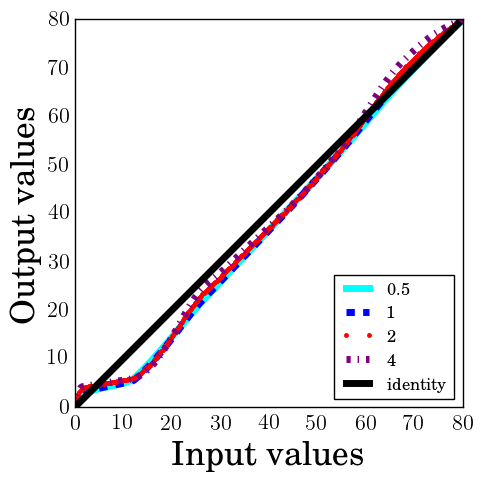

In [150]:
lw = 5

s = 0.5
x2, mmap = ENHANCERS[key]._make_transfer(cis.delta * zv, s)
transfer_function = interp1d(x2, mmap * 80, fill_value='extrapolate')
plt.plot(x2 * 80, mmap * 80, color='cyan', linewidth=lw, label='0.5')

s = 1
x2, mmap = ENHANCERS[key]._make_transfer(cis.delta * zv, s)
transfer_function = interp1d(x2, mmap * 80, fill_value='extrapolate')
plt.plot(x2 * 80, mmap * 80, '--', color='blue', linewidth=lw, label='1')

s = 2
x2, mmap = ENHANCERS[key]._make_transfer(cis.delta * zv, s)
transfer_function = interp1d(x2, mmap * 360, fill_value='extrapolate')
plt.plot(x2 * 80, mmap * 80, '.', markersize=6, color='red', linewidth=lw, label='2')

s = 4
x2, mmap = ENHANCERS[key]._make_transfer(cis.delta * zv, s)
transfer_function = interp1d(x2, mmap * 80, fill_value='extrapolate')
plt.plot(x2 * 80, mmap * 80, '-.', color='purple', linewidth=lw, label='4')

plt.plot(np.arange(80), np.arange(80), color='black', linewidth=lw, label='identity')

plt.xlabel('Input values', fontsize=24)
plt.ylabel('Output values', fontsize=24)
plt.tick_params(axis=u'both', which=u'both',length=0, labelsize=16)
plt.legend(loc='lower right')

plt.savefig('Enhancement function/tone-function.eps', format='eps', dpi=1000, bbox_inches='tight')

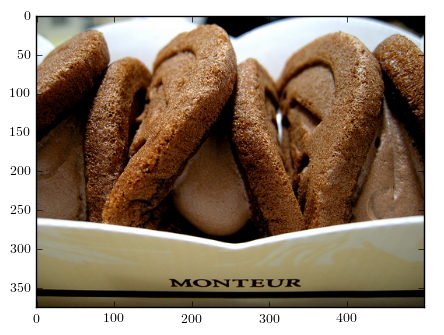

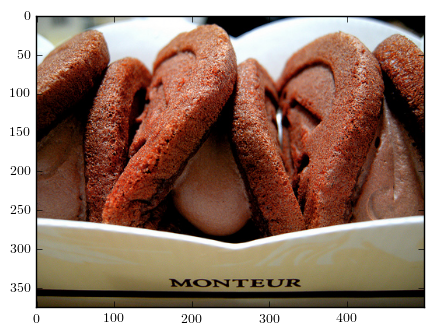

In [151]:
enh = ENHANCERS[key].enhance(image, cis.delta * zv, 2)
enh = (enh * g_mask + (1 - g_mask) * image).astype(np.uint8)
plt.imshow(image)
plt.show()
plt.imshow(enh)

imsave('Enhancement function/original.jpg', image)
imsave('Enhancement function/enhanced.jpg', enh)